In [1]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# locoalhost:5000
mlflow.set_tracking_uri('http://localhost:8080')
#set your experiment name here
mlflow.set_experiment('First-experiment')

2025/09/02 15:12:34 INFO mlflow.tracking.fluent: Experiment with name 'First-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/536260424841273527', creation_time=1756818754608, experiment_id='536260424841273527', last_update_time=1756818754608, lifecycle_stage='active', name='First-experiment', tags={}>

- Load and prepare the Iris dataset for modeling.

- Train a Logistic Regression model and evaluate its performance.

- Prepare the model hyperparameters and calculate metrics for logging

In [4]:
# Load the Iris dataset
X, y = datasets.load_iris(return_X_y=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define the model hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

In [6]:
# Train the model
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

/home/hicham/MLflow-Workshop/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Log the model and hyperparameters to MLflow:

- Initiate an MLflow run context to start a new run that we will log the model and metadata to.

- Log model parameters and performance metrics.

- Tag the run for easy retrieval.

- Register the model in the MLflow Model Registry while logging (saving) the model.

In [7]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="iris_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

2025/09/02 15:14:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'tracking-quickstart'.
2025/09/02 15:14:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, version 1
Created version '1' of model 'tracking-quickstart'.


🏃 View run adaptable-loon-102 at: http://localhost:8080/#/experiments/536260424841273527/runs/0f86e2eb9866446a9183e4f746da6b78
🧪 View experiment at: http://localhost:8080/#/experiments/536260424841273527


### Load the Model and Test it

In [8]:
# Load as PyFuncModel for Pandas DataFrame

loaded_model = mlflow.pyfunc.load_model(model_uri="models:/tracking-quickstart/1")

In [9]:
predictions = loaded_model.predict(X_test)

In [10]:
iris_feature_names = datasets.load_iris().feature_names

result = pd.DataFrame(X_test, columns=iris_feature_names)
result["actual_class"] = y_test
result["predicted_class"] = predictions

result[:4]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),actual_class,predicted_class
0,6.1,2.8,4.7,1.2,1,1
1,5.7,3.8,1.7,0.3,0,0
2,7.7,2.6,6.9,2.3,2,2
3,6.0,2.9,4.5,1.5,1,1


Classification report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



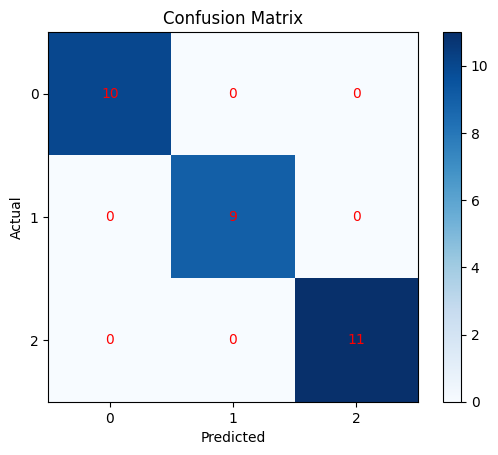

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Rapport
print("Classification report :")
print(classification_report(y_test, predictions))

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(y_test)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Ajouter les valeurs dans les cases
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red")

plt.show()
